In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

Best:	0.0 None None


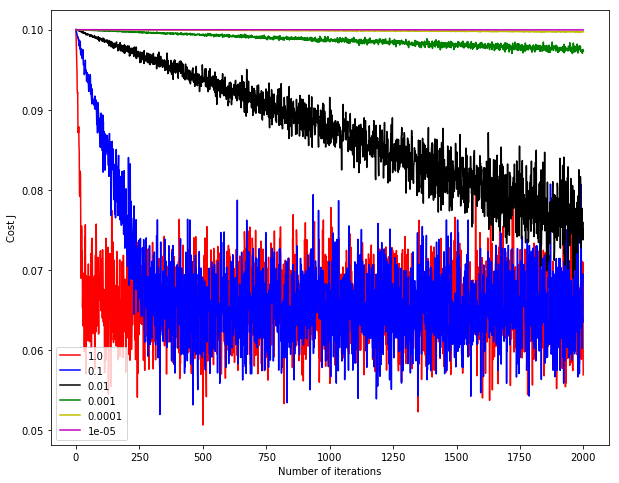

In [34]:
from sklearn import preprocessing, metrics
import utils
import scipy.io
import numpy as np
from linear_classifier import LinearSVM_twoclass

# load the SPAM email training dataset

X,y = utils.load_mat('data/spamTrain.mat')
yy = np.ones(y.shape)
yy[y==0] = -1

X_train = X[:3000] # <--- training data
yy_train = yy[:3000] # <--- training label

X_val = X[3000:] # <--- validation data
yy_val = yy[3000:] # <--- validation label

# load the SPAM email test dataset

test_data = scipy.io.loadmat('data/spamTest.mat')
X_test = test_data['Xtest'] # <--- testing label
y_test = test_data['ytest'].flatten()

yy_test = np.ones(y_test.shape)
yy_test[y_test == 0] = -1 # <--- testing label

##################################################################################
#  YOUR CODE HERE for training the best performing SVM for the data above.       #
#  what should C be? What should num_iters be? Should X be scaled?               #
#  should X be kernelized? What should the learning rate be? What should the     #
#  number of iterations be?                                                      #
##################################################################################

K = np.array([utils.hamming_distance_kernel(x1,x2) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.hamming_distance_kernel(x1,x2) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scalerval.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Ktest = np.array([utils.hamming_distance_kernel(x1,x2) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
scalertest = preprocessing.StandardScaler().fit(Ktest)
scaleKtest = scalertest.transform(Ktest)
KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T


In [ ]:
color = ['r','b','k','g','y','m']
Cvals = [0.01,0.03,0.1,0.3,1,3,10,30]
LearningRatevals = [1e-0,1e-1,1e-2,1e-3,1e-4,1e-5]
# Cvals = [0.1]

color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for LR in LearningRatevals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=LR,reg=0.1,num_iters=2000,verbose=False,batch_size=500)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in LearningRatevals])
plt.show()
fig.savefig("./fig_learning_rate.pdf", format='pdf')

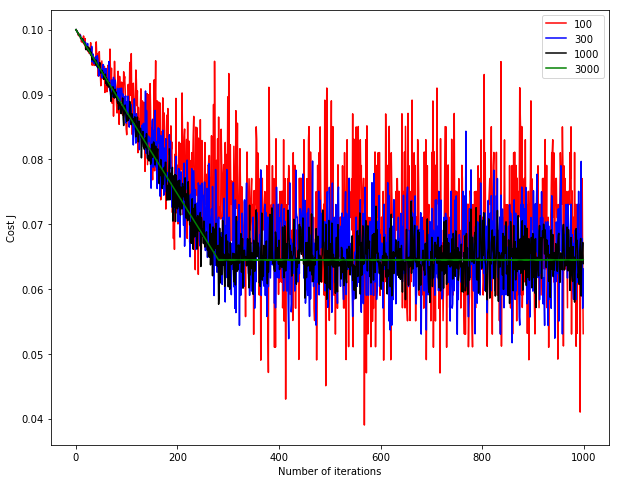

In [47]:
color_idx = 0
fig = plt.figure()
Best_learning_rate = 1e-1
BatchSizes = [100,300,1000,3000]
ax = fig.add_subplot(1,1,1)
for BS in BatchSizes:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=0.1,num_iters=1000,verbose=False,batch_size=BS)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in BatchSizes])
plt.show()
fig.savefig("./fig_batch_size.pdf", format='pdf')

Best:	0.0 None None


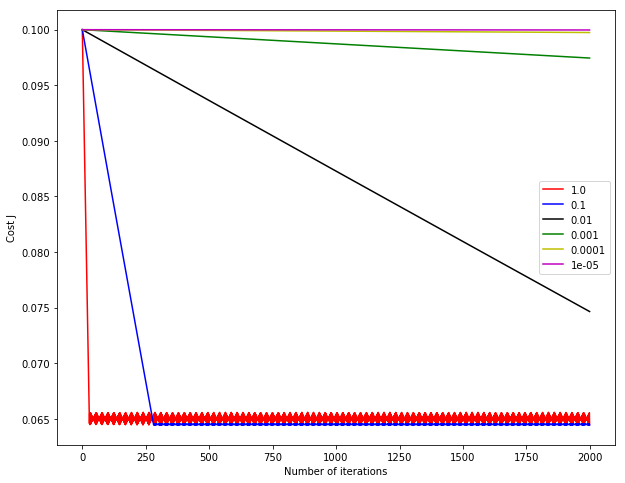

In [48]:
color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for LR in LearningRatevals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=LR,reg=0.1,num_iters=2000,verbose=False,batch_size=3000)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in LearningRatevals])
plt.show()
fig.savefig("./fig_learning_rate.pdf", format='pdf')

In [56]:
color_idx = 0
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
Cvals = [0.01,0.03,0.1,0.3,1,3,10,30]
for C in Cvals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=0.03,reg=C,num_iters=1000,verbose=False,batch_size=3000)

    yy_predval = svm.predict(KKval)
    accuracy = 1.0 * np.sum(yy_predval == yy_val)/yy_val.shape[0]
    print "Best:\t", accuracy, C
#     plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
# plt.xlabel('Number of iterations')
# plt.ylabel('Cost J')
# plt.legend([str(a) for a in LearningRatevals])
# plt.show()
# fig.savefig("./fig_learning_rate.pdf", format='pdf')

Best:	0.687 0.01
Best:	0.687 0.03
Best:	0.687 0.1
Best:	0.687 0.3
Best:	0.687 1
Best:	0.687 3
Best:	0.687 10
Best:	0.687 30


In [54]:
Best_C = None
Best_sigma = None
Best_accuracy = 0.0

# svm = LinearSVM_twoclass()
# svm.theta = np.zeros((X.shape[1],))


##################################################################################
# YOUR CODE HERE for testing your best model's performance                       #
# what is the accuracy of your best model on the test set? On the training set?  #
##################################################################################



##################################################################################
# ANALYSIS OF MODEL: Print the top 15 words that are predictive of spam and for  #
# ham. Hint: use the coefficient values of the learned model                     #
##################################################################################
words, inv_words = utils.get_vocab_dict()

##################################################################################
#                    END OF YOUR CODE                                            #
##################################################################################

Best:	0.678666666667
